In [12]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import convolve2d
from skimage.io import imread

In [13]:
rootfolder = '..'

Define the function to compute the kernel given the weights and the degree of the polynomial

In [14]:
def compute_2D_LPA_kernel(w, N):
  # compute the 2D LPA kernel for a given weights and polynomial degree
  # input:
  #   w: matrix containing the weights for the local LS problem
  #   N: degree of the polynomial approximation
  # return:
  #   g: the computed LPA kernel

  
  # window size is the lenght of the weight vector
  r, c = w.shape
  M = r*c
  
  # create the matrix T
  tx = np.linspace(0, 1, c)
  ty = np.linspace(0, 1, r)
  tx, ty = np.meshgrid(tx, ty)
  tx = tx.reshape(-1)
  ty = ty.reshape(-1)
  T = np.zeros((M,(N+1)**2))
  cnt = 0
  for i in range(N+1):
      for j in range(N-i+1):
          if i==0 and j==0:
              T[:, cnt] = np.ones(M)
          else:
              T[:, cnt] = tx**i * ty**j
          cnt = cnt + 1
  T = T[:, :cnt]

  # unroll the matrix of the weights    
  w = w.reshape(-1)

  # generate the inverse of weights
  winv = 1/w
  
  # set to zero weights that are inf
  winv[winv == np.inf] = 0

  # define the weight matrix
  W = np.diag(w)
  Winv = np.diag(winv)

  ## construct the LPA kernel
  
  # comput the qr decomposition of WT
  Q, _ = np.linalg.qr(W.T @ T)

  # define Qtilde
  Qtilde = np.dot(Winv, Q)
  
  # adjust Qtilde with the weights matrix squared
  W2Qtilde = np.dot(W**2, Qtilde)

  # select the central row of W2Qtilde
  row = M//2 

  # compute the kernel
  g_bar = W2Qtilde @ W2Qtilde[row, :]

  #reshape the kernel in a matrix
  g_bar = g_bar.reshape(r, c)
  
  # flipping, since it is used in convolution
  g = np.flip(g_bar)

  return g


Load the image and add the noise

In [15]:
img = imread(f'{rootfolder}/data/cameraman.png') / 255

sigma_noise = 20/255
noisy_img = img + np.random.normal(size=img.shape) * sigma_noise

psnr_noisy =  10 * np.log10(1 / np.mean((noisy_img - img) ** 2))


Text(0.5, 1.0, 'Noisy image, PSNR = 22.13')

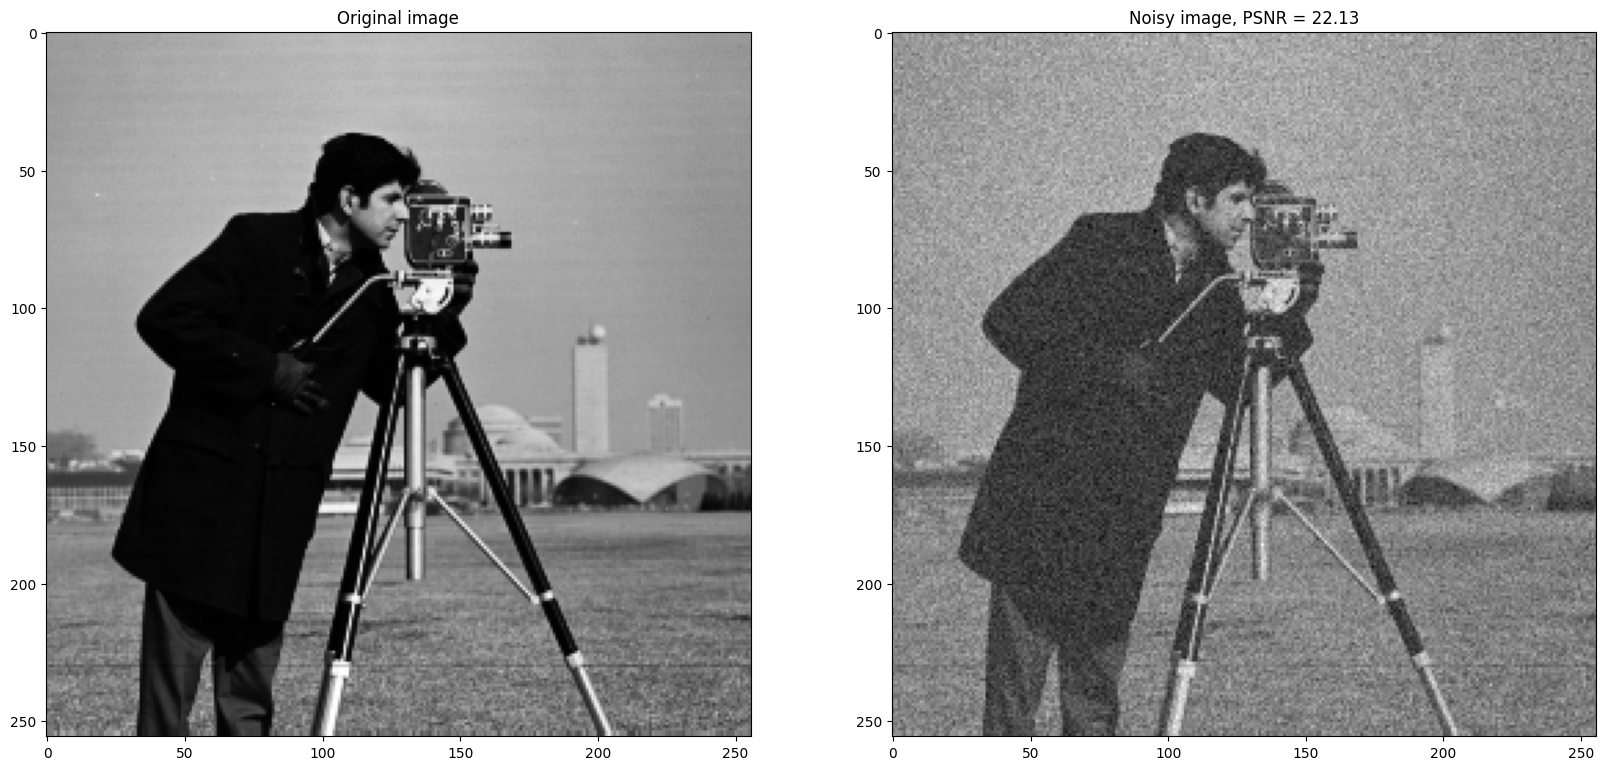

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')

LPA-ICI 2D
----------
Set the LPA-ICI parameters

In [17]:
# maximum degree of polynomial used for fitting
N = 5

# parameter for the confidence intervals in the ICI rule
Gamma = 2

# Set all the scale values
hmax = 21
all_h = np.arange(1, hmax+1)

Generate the LPA kernels for all the scale. Use centered weights.


In [18]:
all_g = []
for i, h in enumerate(all_h):
  # define the weights for the scale h symmetric
  M = 2*h+1

  # size of the weight MATRIX
  w = np.ones((M,M))

  # compute and store the kernel g
  g = compute_2D_LPA_kernel(w, N)
  all_g.append(g)

Initialize all the variables for the ICI rule

In [19]:
# initialize the estimate for each scale
yhat = np.zeros((img.shape))

# initialize the vector containing the best scale for each sample
best_scale = np.zeros(shape=yhat.shape)

# initialize the lower and upper bound matrices
lower_bounds = - np.inf * np.ones(shape=yhat.shape)
upper_bounds = np.inf * np.ones(shape=yhat.shape) 

Loop over all the scales

In [20]:
for i, h in enumerate(all_h):
  g = all_g[i]

  # compute the estimate for the scale h
  yhat_h = convolve2d(noisy_img, g, mode='same')
  
  shat = sigma_noise * np.linalg.norm(g,2)

  # compute the lower and upper bound of the confidence interval for the scale h
  lb = yhat_h - Gamma * shat
  ub = yhat_h + Gamma * shat

  # update the lower and upper bounds
  lower_bounds = np.maximum(lower_bounds, lb)
  upper_bounds = np.minimum(upper_bounds, ub)

  # identify for which samples h is the best scale according to the
  # ICI rule and update the best_scale vector accordingly
  # update best_scale
  best_scale[lower_bounds < upper_bounds] = h

  # update the estimate
  # update yhat
  yhat[lower_bounds < upper_bounds] = yhat_h[lower_bounds < upper_bounds]

Compute the PSNR

In [21]:
psnr =  10 * np.log10(1 / np.mean((yhat - img) ** 2))

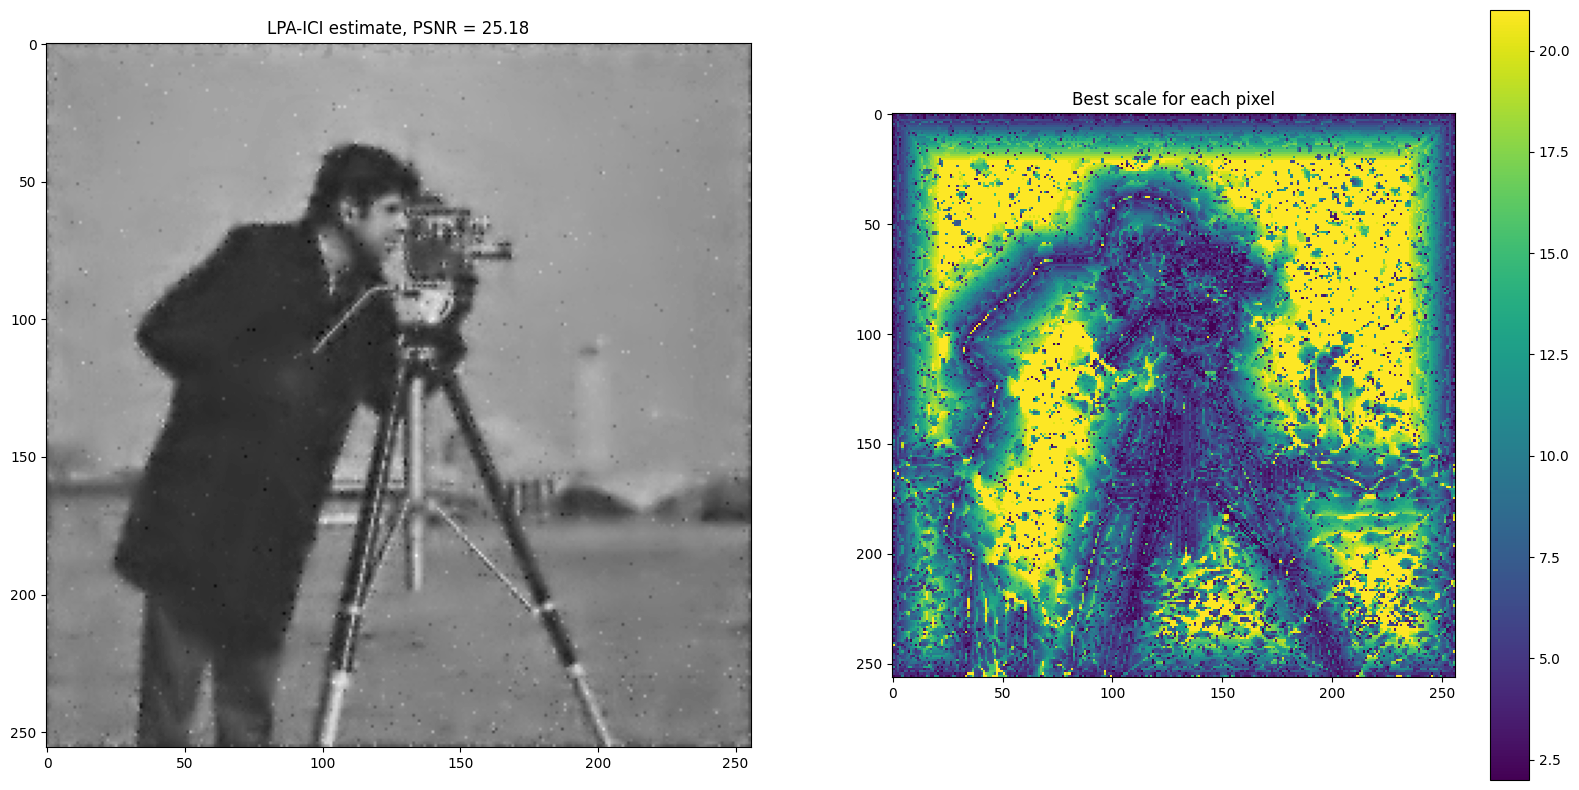

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(yhat, cmap='gray')
ax[0].set_title(f'LPA-ICI estimate, PSNR = {psnr:.2f}')

ax[1].imshow(best_scale)
ax[1].set_title('Best scale for each pixel')
fig.colorbar(ax[1].pcolormesh(best_scale), ax=ax[1])

Anisotropic LPA-ICI
------------------------
Set the parameters


In [23]:
# maximum degree of polynomial used for fitting
N = 5

# parameter for the confidence intervals in the ICI rule
Gamma = 2

# Set all the scale values
hmax = 51
all_h = np.arange(1, hmax+1)

# set all the direction values
all_theta = np.arange(4)

Generate the LPA kernels for all the scales and all the directions

In [24]:
all_g = []

for theta in all_theta:
  all_g_theta = []
  for i, h in enumerate(all_h):
    M = 2*h+1
    w = np.zeros((M,M))
    
    # define the weights for the scale h and the direction theta
    if theta == 0:
      w[:h+1, h:] = 1
    elif theta ==1:
      w[:h+1,:h+1] = 1
    elif theta == 2:
      w[h:, :h+1] = 1
    elif theta == 3:
      w[h:, h:] = 1

    # compute and store the kernel g
    g = compute_2D_LPA_kernel(w, N)

    all_g_theta.append(g)

  all_g.append(all_g_theta)


/var/folders/8g/fgfxv9zs0mqf54m85lvfshww0000gn/T/ipykernel_50742/3426271598.py:35: RuntimeWarning: divide by zero encountered in divide
  winv = 1/w


Initialize all the variables 

In [25]:
# initialize the estimate for each scale
yhat = np.zeros(img.shape)

# initialize the matrix of the aggregation weights
weights = np.zeros(img.shape)


Use the LPA-ICI to compute find the best scale for each direction and compute the finale estimates

In [26]:
# loop over all the directions
for theta in all_theta:
  # initialize the estimate for the direction theta
  yhat_theta = np.zeros(img.shape) 
  
  # initialize the matrix all the variances for the direction theta
  var_theta = np.zeros(img.shape) 

  # initialize the lower and upper bounds matrices
  lower_bounds = - np.inf * np.ones(img.shape)
  upper_bounds = np.inf * np.ones(img.shape)

  # loop over all scales
  all_g_theta = all_g[theta]
  for i, h in enumerate(all_h):
    g = all_g_theta[i]
    shat = sigma_noise * np.linalg.norm(g,2)

    # compute the estimate for the scale h
    yhat_h = convolve2d(noisy_img, g, mode='same') 

    # compute the lower and upper bound of the confidence interval for the scale h
    lb = yhat_h - Gamma * shat
    ub = yhat_h + Gamma * shat

    # update the lower and upper bounds
    lower_bounds = np.maximum(lower_bounds, lb)
    upper_bounds = np.minimum(upper_bounds, ub)

    # update the estimate
    # update yhat_theta
    yhat_theta[lower_bounds < upper_bounds] = yhat_h[lower_bounds < upper_bounds]

    # update the matrix with the variances
    # update var_theta
    var_theta[lower_bounds < upper_bounds] = shat
    
  # update the estimates and the weights
  yhat = yhat + yhat_theta / var_theta**2
  weights = weights + 1 / var_theta**2

# compute the final estimates
yhat = yhat / weights

Compute the PSNR

In [27]:
psnr = 10 * np.log10(1 / np.mean((yhat - img) ** 2))

Text(0.5, 1.0, 'LPA-ICI estimate, PSNR = 26.43')

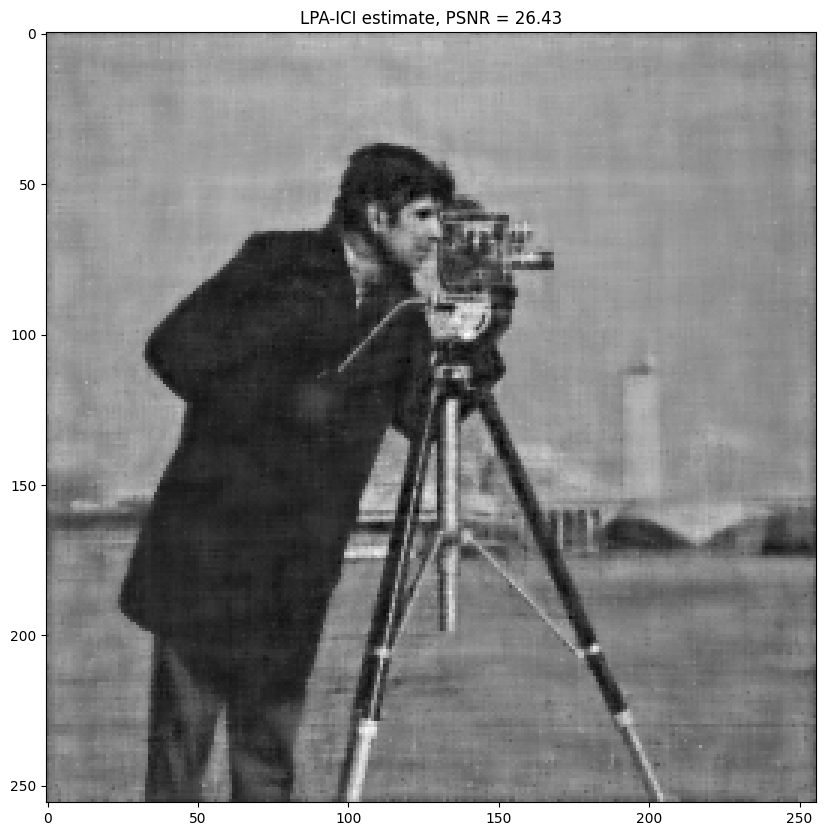

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(yhat, cmap='gray')
plt.title(f'LPA-ICI estimate, PSNR = {psnr:.2f}')
